<h1> <center> <b> Types of Cancer Classification using SVM.

In this notebook, We used SVM (Support Vector Machines) to build and train a model using human cell records, and classify cells to whether the samples are benign or malignant.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initial-Setup" data-toc-modified-id="Initial-Setup-1">Initial Setup</a></span></li><li><span><a href="#Data-Overview" data-toc-modified-id="Data-Overview-2">Data Overview</a></span></li><li><span><a href="#Loading-Data" data-toc-modified-id="Loading-Data-3">Loading Data</a></span></li><li><span><a href="#Data-pre-processing-and-selection" data-toc-modified-id="Data-pre-processing-and-selection-4">Data pre-processing and selection</a></span></li><li><span><a href="#Correlation-Matrix" data-toc-modified-id="Correlation-Matrix-5">Correlation Matrix</a></span></li><li><span><a href="#Selection" data-toc-modified-id="Selection-6">Selection</a></span></li><li><span><a href="#Train/Test-dataset" data-toc-modified-id="Train/Test-dataset-7">Train/Test dataset</a></span></li><li><span><a href="#Modeling-(SVM-with-Scikit-learn)" data-toc-modified-id="Modeling-(SVM-with-Scikit-learn)-8">Modeling (SVM with Scikit-learn)</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-9">Evaluation</a></span></li><li><span><a href="#F1-Score" data-toc-modified-id="F1-Score-10">F1-Score</a></span></li><li><span><a href="#Jaccard-Index" data-toc-modified-id="Jaccard-Index-11">Jaccard Index</a></span></li><li><span><a href="#Accuracy-Score" data-toc-modified-id="Accuracy-Score-12">Accuracy Score</a></span></li><li><span><a href="#Logloss" data-toc-modified-id="Logloss-13">Logloss</a></span></li><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-14">Confusion matrix</a></span></li><li><span><a href="#Best-Model-Selection" data-toc-modified-id="Best-Model-Selection-15">Best Model Selection</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-16">Reference</a></span></li></ul></div>

## Initial Setup

In [64]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Data Overview

This work is based on a dataset that is publicly available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28original). The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

|Field name|Description|Range|
| --- | --- | --- |
|ID|Sample code number|id number|
|Clump|Clump thickness|1 - 10|
|UnifSize|Uniformity of cell size|1 - 10|
|UnifShape|Uniformity of cell shape|1 - 10|
|MargAdh|Marginal adhesion|1 - 10|
|SingEpiSize|Single epithelial cell size|1 - 10|
|BareNuc|Bare nuclei|1 - 10|
|BlandChrom|Bland chromatin|1 - 10|
|NormNucl|Normal nucleoli|1 - 10|
|Mit|Mitoses|1 - 10|
|Class|Benign or malignant|(2 for benign, 4 for malignant)|

<br>
<br>

## Loading Data 

In [61]:
path="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv"

In [62]:
cell_df = pd.read_csv(path)
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

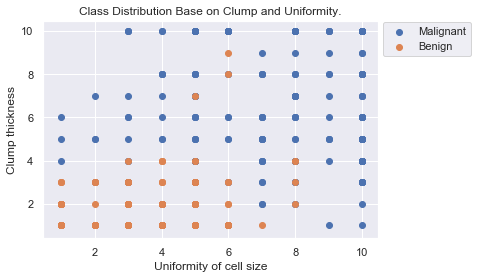

In [175]:
selection_m=cell_df[cell_df['Class'] == 4]
selection_b=cell_df[cell_df['Class'] == 2]

x_m,y_m=selection_m.Clump,selection_m.UnifSize
x_b,y_b=selection_b.Clump,selection_b.UnifSize

fig, ax=plt.subplots()
ax.scatter(x_m,y_m,label='Malignant')
ax.scatter(x_b,y_b,label='Benign')
ax.set_title("Class Distribution Base on Clump and Uniformity.")
ax.set_ylabel("Clump thickness")
ax.set_xlabel("Uniformity of cell size")
plt.legend(bbox_to_anchor=(1, 1.02))
plt.savefig("img/svm1.png", dpi=300, bbox_inches='tight')
plt.show()

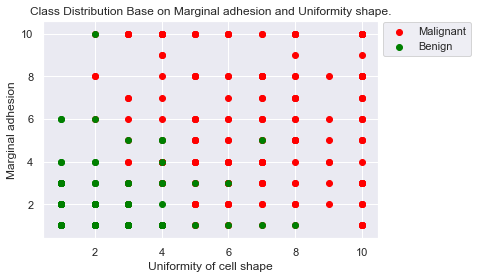

In [176]:
selection_m=cell_df[cell_df['Class'] == 4]
selection_b=cell_df[cell_df['Class'] == 2]

x_m,y_m=selection_m.UnifShape,selection_m.MargAdh
x_b,y_b=selection_b.UnifShape,selection_b.MargAdh

fig, ax=plt.subplots()
ax.scatter(x_m,y_m,label='Malignant', color="red")
ax.scatter(x_b,y_b,label='Benign', color='green')
ax.set_title("Class Distribution Base on Marginal adhesion and Uniformity shape.")
ax.set_ylabel("Marginal adhesion")
ax.set_xlabel("Uniformity of cell shape")
plt.legend(bbox_to_anchor=(1, 1.02))
plt.savefig("img/svm2.png", dpi=300, bbox_inches='tight')
plt.show()

## Data pre-processing and selection

Lets first look at columns data types:

In [86]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [87]:
cell_df.BareNuc.value_counts()

1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: BareNuc, dtype: int64

It looks like the __BareNuc__ column includes some values that are not numerical. We can drop those rows:

In [89]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

## Correlation Matrix

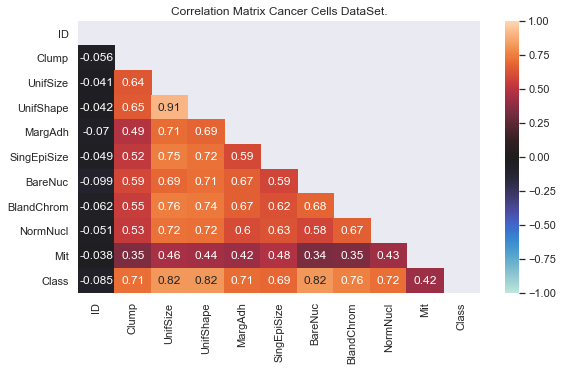

In [177]:
corr = cell_df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(9, 5))
sns.heatmap(corr, mask=mask,annot = True,vmin = -1, vmax = 1, center = 0)
plt.title("Correlation Matrix Cancer Cells DataSet.")
plt.savefig("img/svm3.png", dpi=300, bbox_inches='tight')
plt.show()


## Selection

Let's select feature and target cells.

In [119]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). 

In [121]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y [0:5]

array([2, 2, 2, 2, 2])

## Train/Test dataset

Okay, we split our dataset into train and test set:

In [122]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


<h2 id="modeling">Modeling (SVM with Scikit-learn)</h2>

The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

    1.Linear
    2.Polynomial
    3.Radial basis function (RBF)
    4.Sigmoid
Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.

In [123]:
from sklearn import svm

In [128]:
clf_linear = svm.SVC(kernel='linear')
clf_linear.fit(X_train, y_train) 

clf_poly = svm.SVC(kernel='poly')
clf_poly.fit(X_train, y_train) 

clf_rbf = svm.SVC(kernel='rbf')
clf_rbf.fit(X_train, y_train) 

clf_sig = svm.SVC(kernel='sigmoid')
clf_sig.fit(X_train, y_train) 


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [13]:
yhat = clf.predict(X_test)
yhat [0:5]

array([2, 4, 2, 4, 2])

<h2 id="evaluation">Evaluation</h2>

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

## F1-Score

In [130]:
yhat = clf_linear.predict(X_test)
print('Linear: ', f1_score(y_test, yhat, average='weighted'))
yhat = clf_poly.predict(X_test)
print('Poly: ', f1_score(y_test, yhat, average='weighted'))
yhat = clf_rbf.predict(X_test)
print('Rdf: ', f1_score(y_test, yhat, average='weighted'))
yhat = clf_sig.predict(X_test)
print('Sigmoid: ', f1_score(y_test, yhat, average='weighted'))

Linear:  0.9639038982104676
Poly:  0.9710669934861801
Rdf:  0.9639038982104676
Sigmoid:  0.3714602361753353


## Jaccard Index

Lets try jaccard index for accuracy:

In [131]:
#In not binary predictions post_label= positive prediction
yhat = clf.predict(X_test)
jaccard_score(y_test, yhat, pos_label=2)

yhat = clf_linear.predict(X_test)
print('Linear: ', jaccard_score(y_test, yhat,pos_label=2 ))
yhat = clf_poly.predict(X_test)
print('Poly: ', jaccard_score(y_test, yhat,pos_label=2 ))
yhat = clf_rbf.predict(X_test)
print('Rdf: ', jaccard_score(y_test, yhat,pos_label=2 ))
yhat = clf_sig.predict(X_test)
print('Sigmoid: ', jaccard_score(y_test, yhat,pos_label=2 ))

Linear:  0.9444444444444444
Poly:  0.9555555555555556
Rdf:  0.9444444444444444
Sigmoid:  0.39416058394160586


## Accuracy Score

In [133]:
yhat = clf_linear.predict(X_test)
print('Linear: ', accuracy_score(y_test, yhat))
yhat = clf_poly.predict(X_test)
print('Poly: ', accuracy_score(y_test, yhat))
yhat = clf_rbf.predict(X_test)
print('Rdf: ', accuracy_score(y_test, yhat))
yhat = clf_sig.predict(X_test)
print('Sigmoid: ', accuracy_score(y_test, yhat))

Linear:  0.9635036496350365
Poly:  0.9708029197080292
Rdf:  0.9635036496350365
Sigmoid:  0.39416058394160586


## Logloss

In [134]:
yhat = clf_linear.predict(X_test)
print('Linear: ', log_loss(y_test, yhat, labels=[ 2, 4], normalize=True))
yhat = clf_poly.predict(X_test)
print('Poly: ', log_loss(y_test, yhat, labels=[ 2, 4], normalize=True))
yhat = clf_rbf.predict(X_test)
print('Rdf: ',log_loss(y_test, yhat, labels=[ 2, 4], normalize=True))
yhat = clf_sig.predict(X_test)
print('Sigmoid: ',log_loss(y_test, yhat, labels=[ 2, 4], normalize=True))

Linear:  22.69023240372758
Poly:  22.69023240372758
Rdf:  22.69023240372758
Sigmoid:  22.69023240372758


## Confusion matrix

Another way of looking at accuracy of classifier is to look at __confusion matrix__.

In [136]:
from sklearn.metrics import classification_report, confusion_matrix

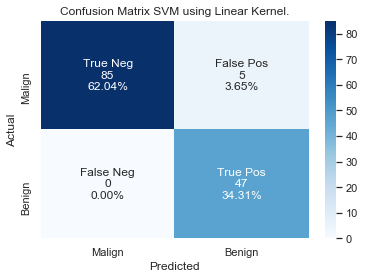

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137



In [165]:
# Compute confusion matrix with linear kernel
yhat = clf_linear.predict(X_test)
cf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.xaxis.set_ticklabels(['Malign', 'Benign'])
ax.yaxis.set_ticklabels(['Malign', 'Benign'])
ax.set_title("Confusion Matrix SVM using Linear Kernel.")
#plt.savefig("img/logr1.png", dpi=300)
plt.show()
print (classification_report(y_test, yhat))

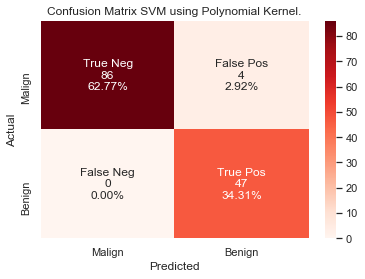

              precision    recall  f1-score   support

           2       1.00      0.96      0.98        90
           4       0.92      1.00      0.96        47

    accuracy                           0.97       137
   macro avg       0.96      0.98      0.97       137
weighted avg       0.97      0.97      0.97       137



In [178]:
# Compute confusion matrix with linear kernel
yhat = clf_poly.predict(X_test)
cf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Reds', ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.xaxis.set_ticklabels(['Malign', 'Benign'])
ax.yaxis.set_ticklabels(['Malign', 'Benign'])
ax.set_title("Confusion Matrix SVM using Polynomial Kernel.")
plt.savefig("img/svm4.png", dpi=300, bbox_inches='tight')
plt.show()
print (classification_report(y_test, yhat))

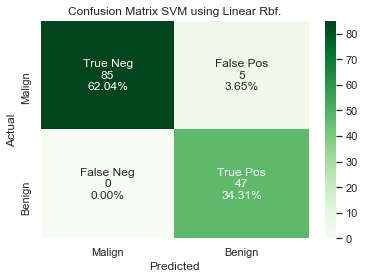

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137



In [166]:
# Compute confusion matrix with linear kernel
yhat = clf_rbf.predict(X_test)
cf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Greens', ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.xaxis.set_ticklabels(['Malign', 'Benign'])
ax.yaxis.set_ticklabels(['Malign', 'Benign'])
ax.set_title("Confusion Matrix SVM using Linear Rbf.")
#plt.savefig("img/logr1.png", dpi=300)
plt.show()
print (classification_report(y_test, yhat))

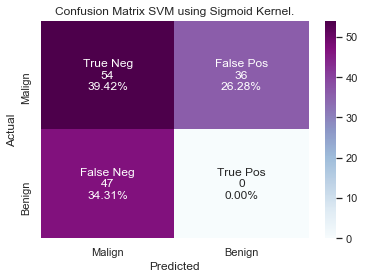

              precision    recall  f1-score   support

           2       0.53      0.60      0.57        90
           4       0.00      0.00      0.00        47

    accuracy                           0.39       137
   macro avg       0.27      0.30      0.28       137
weighted avg       0.35      0.39      0.37       137



In [167]:
# Compute confusion matrix with linear kernel
yhat = clf_sig.predict(X_test)
cf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='BuPu', ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.xaxis.set_ticklabels(['Malign', 'Benign'])
ax.yaxis.set_ticklabels(['Malign', 'Benign'])
ax.set_title("Confusion Matrix SVM using Sigmoid Kernel.")
#plt.savefig("img/logr1.png", dpi=300)
plt.show()
print (classification_report(y_test, yhat))

## Best Model Selection

As we can see the Polynomial Kernel have best scores.

## Reference

**Dr. Saeed Aghabozorgi**, Machine Learning IBM Cognitive Class